# <center> Sales train analysis

## Summary

### Columns

- **date** - date in format ``dd/mm/yyyy``
- **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- **shop_id** - unique identifier of a shop
- **item_id** - unique identifier of a product
- **item_price** - current price of an item
- **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure

### Insights

1. Some of objects compraise of negative ``item_price`` because min function returned **-1.0** price.
2. Some of objects compraise of negative ``item_cnt_day``. It is said that negative item count means **returned items**. ([kaggle discussion](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/100695#latest-584986))
3. Dataset **does not** consist of any of **NaN values**.
4. There are **28** objects which are duplicates. Duplicated objects consist of same key pairs. Key consist of following columns: ``date``, ``item_id``, ``shop_id``.
5. Month sales by month for all stores and items has trend
6. Sales has negative trend.
7. Sales has seasonal components. The highest sales happens before New Year. Then sales usually decrease.
8. Residuals of sales are too high.
9. Usually all shops have same seasonality.
10. All shops have negative trend.

11. Returned products look more like noise.
12. Portion of returned products are too small - **0.00027109214**
13. There are not correlation between variables.





## Import libraries and datasets

Initially, It needs to load datasets from ETL notebook. These notebooks store in memory of jupyter notebook. To recover them, it needs to run ETL notebook.

In [2]:
%store -r item_cat
%store -r item
%store -r sub
%store -r shops
%store -r sales_test
%store -r sales_train
%store -r __ipy
%store -r __da

In [3]:
__ipy

Helper ipython script loaded


In [4]:
__da

/Users/maksymsuprunenko/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:604: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Basic Data Analysis tools was loaded


## Initial Data Analysis

Glimpse insights from the data:
1. Some of objects compraise of negative ``item_price`` because min function returned **-1.0** price.
2. Some of objects compraise of negative ``item_cnt_day``. It is said that negative item count means **returned items**. ([kaggle discussion](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/100695#latest-584986))
3. Dataset **does not** consist of any of **NaN values**.
4. There are **28** objects which are duplicates. Duplicated objects consist of same key pairs. Key consist of following columns: ``date``, ``item_id``, ``shop_id``.

In [2]:
sales_train.head()

date  date_block_num  shop_id  item_id   item_price  item_cnt_day
0 2013-02-01               0       59    22154   999.000000           1.0
1 2013-03-01               0       25     2552   899.000000           1.0
2 2013-05-01               0       25     2552   899.000000          -1.0
3 2013-06-01               0       25     2554  1709.050049           1.0
4 2013-01-15               0       25     2555  1099.000000           1.0

In [6]:
sales_train.describe()

date_block_num      shop_id      item_id   item_price  item_cnt_day
count    2,935,849.00 2,935,849.00 2,935,849.00 2,935,849.00  2,935,849.00
mean            14.57        33.00    10,197.23       890.62          1.24
std              9.42        16.23     6,324.30     1,726.44          2.61
min              0.00         0.00         0.00        -1.00        -22.00
25%              7.00        22.00     4,476.00       249.00          1.00
50%             14.00        31.00     9,343.00       399.00          1.00
75%             23.00        47.00    15,684.00       999.00          1.00
max             33.00        59.00    22,169.00   307,980.00      2,169.00

In [7]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float32
item_cnt_day      float32
dtypes: datetime64[ns](1), float32(2), int64(3)
memory usage: 112.0 MB


## Monthly sales

Task of competition is to predict sales by month. So I grouped items and shops by `month == date_block_num`.

In [5]:
%%notify
ms = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)\
.agg({'item_price':'median', 'item_cnt_day':'sum'})

<IPython.core.display.Javascript object>

In [8]:
def item_cnt_grouped(df, column, title, cnt=10):    
    grouped_by_shop_date = df[[column, 'date_block_num', 'item_cnt_day']].groupby([column, 'date_block_num'], as_index=False).sum()
    max_samples = grouped_by_shop_date.groupby(column, as_index=False).sum().sort_values(by=['item_cnt_day'], ascending=False).head(cnt)[column]
    grouped_by_shop_date_sorted  = grouped_by_shop_date[np.isin(grouped_by_shop_date[column], max_samples)].sort_values(by=[column, 'date_block_num'])

    def date_cnt_plot(key):
        df = grouped_by_shop_date_sorted[grouped_by_shop_date[column] == key] 
        return go.Scatter(x=df['date_block_num'], y=df['item_cnt_day'], name= title + " " + str(key))
    
    data = [date_cnt_plot(i) for i in grouped_by_shop_date[column].unique()]
    layout = dict(title="Month sales for all stores")
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

### Month sales by month for all stores and items

1. Sales has negative trend.
2. Sales has seasonal components. The highest sales happens before New Year. Then sales usually decrease.
3. Residuals are too high.

In [6]:
grouped_by_date = (
    ms[['date_block_num', 'item_cnt_day']]
    .groupby(['date_block_num'], as_index=False)
    .sum()
    .sort_values(by=['date_block_num']))

px.line(grouped_by_date, y='item_cnt_day', x='date_block_num')

### STL decomposition

In [ ]:
def seasonal_decompose_plot(grouped_by_date, freq=12):
    
    result = sm.tsa.seasonal_decompose(grouped_by_date['item_cnt_day'].values, freq=freq, model="additive")        
    
    date_block_num = grouped_by_date['date_block_num']
    
    plot_names = ['trend', 'seasonal', 'resid', 'observed']
    
    fig = make_subplots(4, 1, shared_xaxes=True, vertical_spacing=0.1,
                       subplot_titles=plot_names)
    
    for i, t in enumerate(plot_names):
        fig.add_trace(
            go.Scatter(
                x=eval(f"date_block_num[np.logical_not(np.isnan(result.{t}))]"),  
                y=eval(f"result.{t}[np.logical_not(np.isnan(result.{t}))]")), 
            row=i+1, col=1)
        
    fig.update_layout(showlegend=False, title_text="Seasonal decompose. ", height=1000)
    fig.show()

In [81]:
seasonal_decompose_plot(grouped_by_date, freq=12)

In [82]:
seasonal_decompose_plot(grouped_by_date, freq=6)

### Monthly sales avg by item (The most popular products)

In [10]:
item_cnt_grouped(ms, 'item_id', title = 'Item: ')

### Monthly sales avg by shop

1. Usually all shops have same seasonality.
2. All shops have negative trend.

In [11]:
item_cnt_grouped(ms, 'shop_id', title = 'Shop:')

### Returned products
1. Returned products look more like noise.
2. Portion of returned products are too small - **0.00027109214**

In [14]:
returned_items = ms[ms['item_cnt_day'] < 0].groupby('date_block_num')\
.sum().reset_index().rename(columns={'item_cnt_day': 'returned_items'})

returned_items['returned_items'] = returned_items['returned_items'] * -1

fig = px.line(returned_items, x="date_block_num", y="returned_items", line_shape="spline")
fig.show()

### Portion of returned products

In [15]:
returned_items['returned_items'].sum() / ms['item_cnt_day'].sum()

0.00027109214

### Months which are available in dataset.

1. Not all products were actual
2. Some of products has gaps between months.

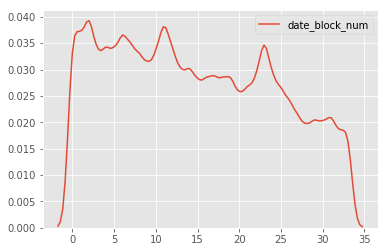

In [17]:
sns.kdeplot(ms['date_block_num'])

### Price distribution among all items. 
1. The most part of items (50%) cost between 0 and 350.
2. Items are not distributed normally. 

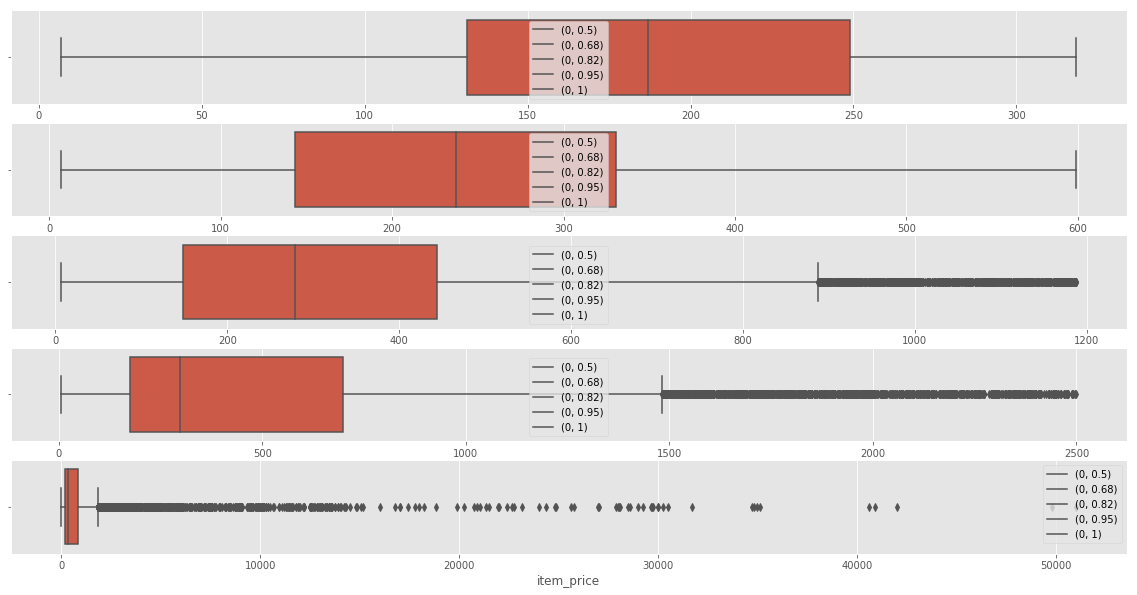

In [18]:
item_price = ms.groupby('item_id')['item_price'].mean()

rang = [0.5, 0.68, 0.82, 0.95, 1]

fig, axes = plt.subplots(len(rang),1, figsize=(20, 10))
for i, ax in zip(rang, axes):    
    q = np.quantile(item_price, (0, i))
    ax = sns.boxplot(item_price[(item_price > q[0]) & (item_price < q[1])], ax =ax)
    fig.add_subplot(ax)
    ax.legend(list(zip(np.repeat(0, len(rang)), rang)))

### Item count distribution among all items. 

Elements count 0.6580133041331805
Max value item_cnt_day   1.00
dtype: float32
Elements count 0.8230111538949143
Max value item_cnt_day   2.00
dtype: float32
Elements count 0.8230111538949143
Max value item_cnt_day   2.00
dtype: float32
Elements count 0.9203025994267688
Max value item_cnt_day   4.00
dtype: float32
Elements count 0.9401730382493829
Max value item_cnt_day   5.00
dtype: float32
Elements count 0.9978261464001531
Max value item_cnt_day   2,253.00
dtype: float32


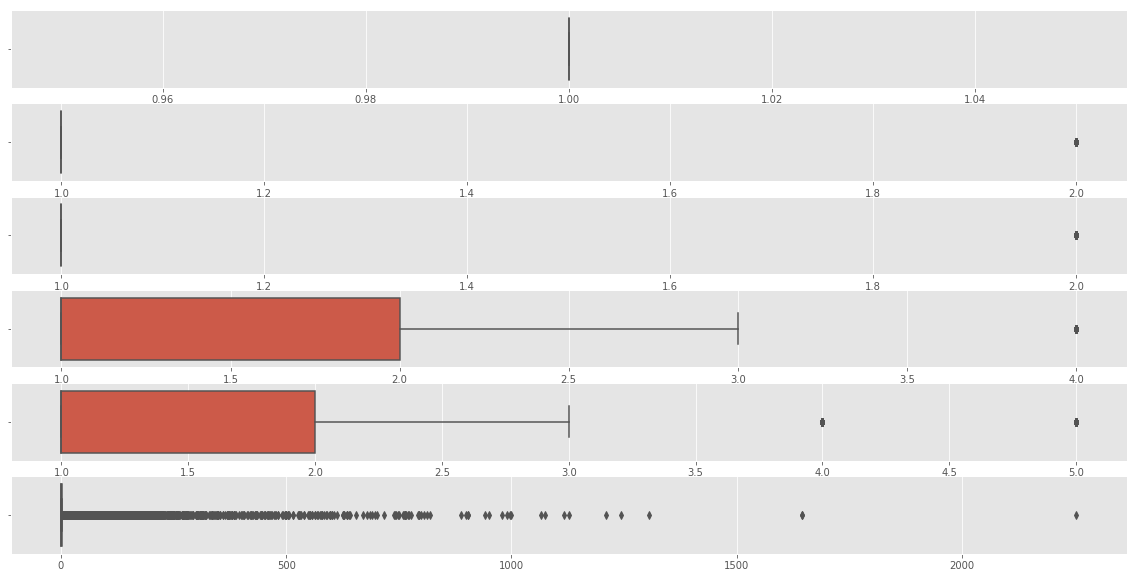

In [85]:
item_cnt_day = ms[['item_cnt_day', 'item_id']].set_index('item_id')

rang = [0.5, 0.68, 0.82, 0.9, 0.93, 1]
fig, axes = plt.subplots(len(rang),1, figsize=(20, 10))

def filter_cnt(item_cnt_day, q):
    return item_cnt_day[(item_cnt_day['item_cnt_day'] >= q[0]) & (item_cnt_day['item_cnt_day'] <= q[1])]
for i, ax in zip(rang, axes.flatten()):    
    q = np.quantile(item_cnt_day, (0.005, i))
    v = filter_cnt(item_cnt_day, q)
    ax = sns.boxplot(v, ax=ax)
 #   ax.legend(list(zip(np.repeat(0, len(raxng)), rang)))
    print("Elements count", np.where(v, 1, 0).sum() / item_cnt_day.shape[0])
    print("Max value", v.max())

## <center> Correlation Analysis

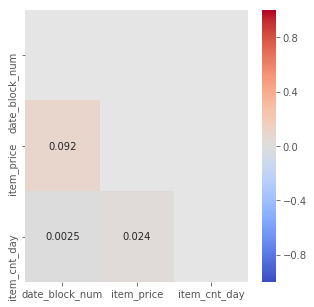

In [27]:
corr = ms.drop(['item_id', 'shop_id'], axis=1).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask = mask);